# Graph Convolutional Network

In [80]:
import torch
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Twitch, GitHub, GNNBenchmarkDataset
import networkx as nkx

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model

In [132]:
class GCN(nn.Module):
    def __init__(self, n: int):
        """
        n: int - number of input features of nodes
        """
        super().__init__()
        self.conv1 = pyg_nn.GCNConv(n, n // 4)
        self.conv2 = pyg_nn.GCNConv(n // 4, n // 8)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        return x


class MLP(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        d1 = int(n**0.5)
        self.layer1 = nn.Linear(n, d1)
        self.layer2 = nn.Linear(d1, 1)
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return torch.sigmoid(x)


class GcnMlpClassifier(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.gcn = GCN(n)
        self.mlp = MLP(n // 8)

    def forward(self, data):
        x = self.gcn(data)
        outs = self.mlp(x)
        return outs

## Training

In [93]:
github = GitHub(root='../data/GitHub')
github

GitHub()

In [134]:
from common import train_model, eval_model, plot_hist

from torch_geometric.transforms import RandomNodeSplit
torch.manual_seed(84)

model = GcnMlpClassifier(github.num_features).to(DEVICE)
data = RandomNodeSplit()(github.data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
loss = nn.BCELoss()

train_hist = train_model(model, loss, optimizer, data, epochs=1500, eval_freq=100)

  0%|          | 7/1500 [00:00<00:42, 34.92it/s]


epoch 0:
tr_loss 0.6272
tr_acc: 0.7419                                 
val_acc: 0.7440


  7%|▋         | 104/1500 [00:02<00:42, 32.66it/s]


epoch 100:
tr_loss 0.5284
tr_acc: 0.8204                                 
val_acc: 0.8180


 14%|█▍        | 207/1500 [00:05<00:33, 39.18it/s]


epoch 200:
tr_loss 0.3582
tr_acc: 0.8640                                 
val_acc: 0.8520


 20%|██        | 307/1500 [00:07<00:30, 39.39it/s]


epoch 300:
tr_loss 0.3316
tr_acc: 0.8673                                 
val_acc: 0.8540


 27%|██▋       | 405/1500 [00:10<00:27, 39.27it/s]


epoch 400:
tr_loss 0.3198
tr_acc: 0.8705                                 
val_acc: 0.8540


 34%|███▍      | 509/1500 [00:12<00:24, 40.85it/s]


epoch 500:
tr_loss 0.3108
tr_acc: 0.8735                                 
val_acc: 0.8500


 41%|████      | 608/1500 [00:15<00:21, 41.16it/s]


epoch 600:
tr_loss 0.3026
tr_acc: 0.8765                                 
val_acc: 0.8580


 47%|████▋     | 708/1500 [00:17<00:19, 41.13it/s]


epoch 700:
tr_loss 0.2946
tr_acc: 0.8802                                 
val_acc: 0.8620


 54%|█████▍    | 807/1500 [00:19<00:16, 41.04it/s]


epoch 800:
tr_loss 0.2863
tr_acc: 0.8847                                 
val_acc: 0.8660


 60%|██████    | 906/1500 [00:22<00:14, 40.97it/s]


epoch 900:
tr_loss 0.2771
tr_acc: 0.8891                                 
val_acc: 0.8680


 67%|██████▋   | 1006/1500 [00:24<00:12, 41.06it/s]


epoch 1000:
tr_loss 0.2683
tr_acc: 0.8928                                 
val_acc: 0.8560


 74%|███████▎  | 1105/1500 [00:27<00:10, 36.89it/s]


epoch 1100:
tr_loss 0.2597
tr_acc: 0.8968                                 
val_acc: 0.8560


 81%|████████  | 1208/1500 [00:29<00:07, 38.65it/s]


epoch 1200:
tr_loss 0.2509
tr_acc: 0.8999                                 
val_acc: 0.8480


 87%|████████▋ | 1308/1500 [00:32<00:04, 40.01it/s]


epoch 1300:
tr_loss 0.2431
tr_acc: 0.9038                                 
val_acc: 0.8500


 94%|█████████▍| 1408/1500 [00:34<00:02, 40.14it/s]


epoch 1400:
tr_loss 0.2359
tr_acc: 0.9067                                 
val_acc: 0.8540


100%|██████████| 1500/1500 [00:36<00:00, 40.84it/s]


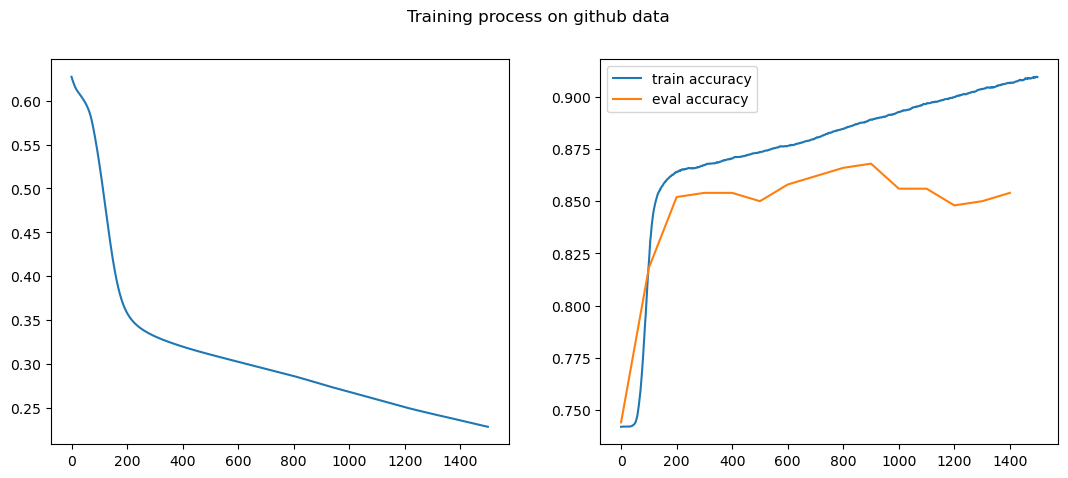

In [135]:
import matplotlib.pyplot as plt

def plot_hist(train_loss_hist, train_acc_hist, eval_acc_hist, eval_freq):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.plot(train_loss_hist, label='train loss')
    ax2.plot(train_acc_hist, label='train accuracy')
    ax2.plot(range(0, len(train_acc_hist), eval_freq), eval_acc_hist, label='eval accuracy')
    plt.suptitle('Training process on github data')
    plt.legend()
    plt.show()

plot_hist(*train_hist, 100)

In [115]:
twitch = Twitch(root='../data/Twitch', name='EN')
twitch.data

Processing...
Done!


Data(x=[7126, 128], edge_index=[2, 77774], y=[7126])

  1%|          | 17/2000 [00:00<00:23, 84.23it/s]


epoch 0:
tr_loss 0.6935
tr_acc: 0.4623                                 
val_acc: 0.5000


 11%|█         | 216/2000 [00:02<00:19, 90.28it/s]


epoch 200:
tr_loss 0.4759
tr_acc: 0.7970                                 
val_acc: 0.5740


 21%|██        | 412/2000 [00:04<00:17, 89.12it/s]


epoch 400:
tr_loss 0.3446
tr_acc: 0.8718                                 
val_acc: 0.5560


 31%|███       | 611/2000 [00:06<00:16, 84.03it/s]


epoch 600:
tr_loss 0.2828
tr_acc: 0.8967                                 
val_acc: 0.5560


 41%|████      | 815/2000 [00:09<00:15, 75.60it/s]


epoch 800:
tr_loss 0.2417
tr_acc: 0.9028                                 
val_acc: 0.5560


 51%|█████     | 1015/2000 [00:12<00:14, 70.34it/s]


epoch 1000:
tr_loss 0.2088
tr_acc: 0.9108                                 
val_acc: 0.5680


 60%|██████    | 1209/2000 [00:14<00:10, 76.86it/s]


epoch 1200:
tr_loss 0.1827
tr_acc: 0.9118                                 
val_acc: 0.5680


 71%|███████   | 1411/2000 [00:17<00:07, 74.98it/s]


epoch 1400:
tr_loss 0.1660
tr_acc: 0.9127                                 
val_acc: 0.5620


 81%|████████  | 1618/2000 [00:19<00:04, 85.23it/s]


epoch 1600:
tr_loss 0.1512
tr_acc: 0.9387                                 
val_acc: 0.5440


 91%|█████████ | 1815/2000 [00:22<00:02, 87.10it/s]


epoch 1800:
tr_loss 0.1419
tr_acc: 0.9410                                 
val_acc: 0.5380


100%|██████████| 2000/2000 [00:24<00:00, 81.20it/s]


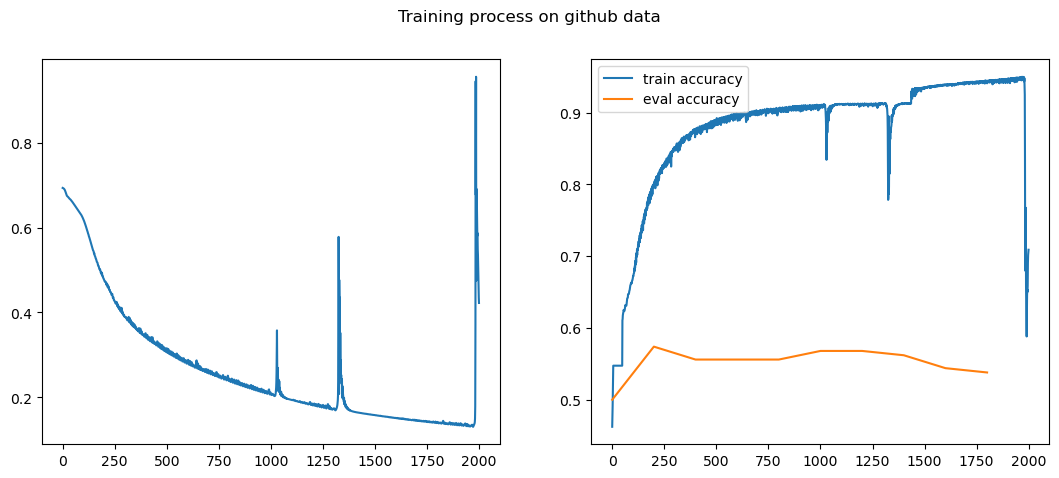

In [137]:
torch.manual_seed(42)

model = GcnMlpClassifier(twitch.num_features).to(DEVICE)
data = RandomNodeSplit()(twitch.data.to(DEVICE))
data.y = data.y.to(torch.float32) # for loss computation
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-3)
loss = nn.BCELoss()

train_hist = train_model(model, loss, optimizer, data, epochs=2000, eval_freq=200)
plot_hist(*train_hist, eval_freq=200)

## Benchmarks